## Ajuste de los parámetros del modelo a datos reales de defunciones

In [1]:
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
url_casos = "https://raw.githubusercontent.com/edtrelo/BioMatematica/main/Modeling%20COVID-19%20Spreading%20in%20the%20ZMVM/data/cleandata/Casos_Diarios_ZMVM_Defunciones.csv"
url_viajes = "https://raw.githubusercontent.com/edtrelo/BioMatematica/main/Modeling%20COVID-19%20Spreading%20in%20the%20ZMVM/data/cleandata/viajes_ZMVM.csv"

In [3]:
def _municipios():
    """Carga el archivo binario que contiene un dataframe con los nombres de los municipios y sus códigos."""
    with open('D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/rawdata/municipios.pkl', 'rb') as handle:
        municipios = pickle.load(handle)
    return municipios

In [4]:
def casos_por_entidad():
    """Obtiene los casos agregados por Entidad.
    
    returns:
        pd.DataFrame: posee una columna llamada población, con la suma de las poblaciones de cada Estado y 
        el resto de columnas representan una fecha donde están reportados el número de casos por entidad.
    """
    casos = pd.read_csv(url_casos, sep = ',', encoding = 'utf-8', index_col = 1)
    casos_ent = casos.groupby("ent").sum() # obtiene la suma de los casos por estado
    return casos_ent

In [5]:
def viajes_por_entidad():
    """Obtiene el número de viajes realizados de una Entidad a otra.
    
    returns:
        pd.DataFrame: la entrada (i,j) es el número de viajes del Estado i al Estado j."""
    viajes = pd.read_csv(url_viajes, sep = ',', encoding = 'utf-8')
    mun = _municipios()
    viajes['ent'] = viajes.nombre.apply(lambda x: mun[mun.nombre == x].iloc[0, 0]) # obtenemos el código de entidad
    viajes_ent = viajes.groupby('ent').sum() # agrupamos por estado y sumamos los viajes
    viajes_ent.set_axis(viajes.ent, axis='columns', inplace=True) # cambia el nombre de las columnas por su entidad
    viajes_ent = viajes_ent.groupby(level = 0, axis = 1).sum() # agrupa las columnas y suma los viajes
    return viajes_ent

In [6]:
def viajes_totales():
    """Obtiene el número de viajes entre municipios."""
    return pd.read_csv(url_viajes, sep = ',', encoding = 'utf-8', index_col = 0)

def casos_totales():
    """Obtiene el número de casos por municipio."""
    return pd.read_csv(url_casos, sep = ',', encoding = 'utf-8', index_col = 1)

In [7]:
def casos_cdmx():
    """Obtiene los casos agregados por alcadía.
    
    returns:
        pd.DataFrame: posee una columna llamada población y el resto de columnas representan una 
        fecha donde están reportados el número de casos por alcaldía.
    """
    casos = pd.read_csv(url_casos, sep = ',', encoding = 'utf-8')
    casos_cdmx = casos[casos['ent'] == 9]  # la cdmx tiene código de entidad igual a 9
    casos_cdmx.set_index('nombre', inplace = True) # cambiamos el índice por el nombre de las alcaldías.
    return casos_cdmx

def viajes_cdmx():
    """Obtiene el número de viajes realizados de una alcaldía a otra.
    
    returns:
        pd.DataFrame: la entrada (i,j) es el número de viajes de la alcadía i a la alcaldía j."""
    viajes = pd.read_csv(url_viajes, sep = ',', encoding = 'utf-8')
    mun = _municipios()
    viajes['ent'] = viajes.nombre.apply(lambda x: mun[mun.nombre == x].iloc[0, 0]) # obtenemos el código de entidad
    viajes = viajes[viajes.ent.to_numpy() == 9] # la cdmx tiene código de entidad igual a 9
    alcaldias = viajes['nombre'].to_numpy() # obtenemos el nombre de las alcaldías
    viajes.set_index('nombre', inplace = True)
    return viajes.loc[:, alcaldias] # solo queremos los viajes dentre de las alcaldías

Cargamos los datos que queremos usar (totales, por entidad, cdmx):

In [8]:
viajes = viajes_por_entidad()
casos = casos_por_entidad()

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_17008\3716804187.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  viajes_ent = viajes.groupby('ent').sum() # agrupamos por estado y sumamos los viajes
C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_17008\3716804187.py:10: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  viajes_ent.set_axis(viajes.ent, axis='columns', inplace=True) # cambia el nombre de las columnas por su entidad


Calculamos $N$ y $\hat{N}$: 

In [9]:
N = casos['poblacion'].to_numpy() # población de M_i

In [10]:
M = viajes.sum().to_numpy() # número de personas que salen de la ciudad i, N gorrito en el modelo.

In [11]:
total_dias = 100 # días que queremos modelar
tmax = total_dias - 1 
tdata = np.linspace(0, tmax, total_dias) # array con los días que queremos modelar.

In [12]:
size = viajes.shape[0] # n, número de patches
# -------------- contantes del modelo ------------------------------ # 
f = 0.1 # porción de infectados que salen de su cada
η = 1/7 # tasa de incubación
γ = 1/21 # tasa de recuperación
ν = 5/12 # tiempo fuera de la ciudad hogar

In [13]:
def _getIndex(*ciudades):
    """Obtiene los índices --- en el orden alfabético de los 47 municipios de la ZMVM con los qu estamos trabajando ----
    de un grupo de ciudades dadas.
    
    returns:
        list"""
    indices = []
    for k in range(size):
        if viajes.index[k] in ciudades:
            indices.append(k)
    return indices

In [14]:
indices = _getIndex('Gustavo A. Madero', 'Iztapalapa', 'Tecamac') # solo cuando usemos datos totales o de cdmx

In [15]:
indices = [0, 2] # cdmx y edo mex tuvieron un caso al inicio

In [16]:
# inicialización de las condiciones iniciales
x0 = []
for k in range(size):
    # S0, E0, I0, R0, D0
    if k in indices: # si uno de los patches fue de los que registró un caso inicial
        x0.extend([N[k] - 1, 0, 1, 0, 0])
    else:
        x0.extend([N[k], 0, 0, 0, 0])

In [17]:
def F(t, X, μ, *Br):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
    
    dXdt = np.zeros(size * 5) # aquí vamos a guardar las expresiones de las derivadas. Cada 5 entradas cambiamos de patch.
    
    def num(i, j):
        """Cantidades de viajes de la ciudad i a la ciudad j."""
        return viajes.iloc[i, j]
    
    def S(i):
        """Suceptibles de la ciudad i."""
        return X[5*i]
        
    def E(i):
        """Expuestos de la ciudad i."""
        return X[5*i + 1]
    
    def I(i):
        """Infectados (confirmados) de la ciudad i."""
        return X[5*i + 2]
    
    def R(i):
        """Recuperados de la ciudad i."""
        return X[5*i + 3]
    
    def D(i):
        """Dinfunntos de la ciudad i."""
        return X[5*i + 4]
    
    def βr(k):
        """Tasa de contacto en la ciudad k."""
        return Br[k]
     
    for i in range(size):
        # X_i; los componentes de cada ciudad
        def Σ(k):
            return sum([num(m, k) * (E(m) + f * I(m))/(N[m] * M[k]) for m in range(size)])
        
        # ecuación de los suceptibles para la ciudad i
        dXdt[5*i + 0] = - ν * S(i)/N[i] * sum([num(i, k) * βr(k) * Σ(k) for k in range(size)]) - βr(i)*(1-ν)*S(i)*(E(i) + f*I(i))/N[i]
        # ecuación de los expuestos para la ciudad i
        dXdt[5*i + 1] = ν * S(i)/N[i] * sum([num(i, k) * βr(k) * Σ(k) for k in range(size)]) + βr(i)*(1-ν)*S(i)*(E(i) + f*I(i))/N[i]
        dXdt[5*i + 1] += -(η+γ)*E(i)
        # ecuación de los infectados para la ciudad i
        dXdt[5*i + 2] = η*E(i) - γ*I(i) - μ*I(i)
        # ecuación de los recuperados para la ciudad i
        dXdt[5*i + 3] = γ*I(i) + γ*E(i)
        # ecuación para los fallecidos para la ciudad i
        dXdt[5*i + 4] = μ*I(i)
        
    return dXdt

In [18]:
def g(Θ):
    """Solución de la ecuación del modelo SEIR"""

    global tmax, x0, tdata
    
    sol = solve_ivp(F, (0, tmax), x0, args = (Θ), t_eval = tdata)
    
    return sol.y

In [19]:
def residual(Θ):
    """Función a optimizar."""
    # obtenemos los valores iniciales 
    global x0
    model = g(Θ)
    # obtenemos las soluciones de los I_k
    modelI = np.zeros( (size, total_dias))
    # extraemos estos valores
    for k in range(size):
        # obtenemos las soluciones correspondientes a los Dinfuntos
        modelI[k] = model[5*k + 4]
    # las defunciones empezaron a registrarse a partir del vigésimo día de registrarse la primer infección
    return (modelI[:, 20:] - data).ravel()

In [20]:
def getdata(tn):
    """Obtiene una matriz con los muertos de cada ciudad, donde cada columna es una ciudad distinta y tn es 
    el número de días a analizar."""
    data = np.zeros((size, tn-20))
    for k in range(size):
        # queremos los primeros tn casos de la ciudad k
        # suma acumulada de las defunciones, queremos los tn - 20 primeros días
        data[k] = casos.iloc[:, 1:-2].cumsum(axis = 1).iloc[k, 1:tn - 19]
    return data

In [21]:
# obtenemos los datos
data = getdata(total_dias)

In [22]:
# creamos un vector con los valores estimados iniciales
g0 = [0.001]
g0.extend([0.5]*size)

Realizamos el ajuste de los datos por medio de **mínimos cuadrados**:

In [23]:
ajuste = least_squares(residual, g0, bounds = ([0]*(size+1), [1]*(size+1)))

In [24]:
# obtenemos el valores de nuestros parámetros
μ = ajuste.x[0]
Βr = ajuste.x[1:]

## Presentación de resultados

In [25]:
# obtenemos la solución numérica a nuestro sistema de ecuaciones
sol = g(ajuste.x)

In [26]:
# obtenemos los valores de los muertos de cada patch
Dcdmx = sol[4]
Dhgo = sol[5 + 4]
Dedomex = sol[5*2 + 4]

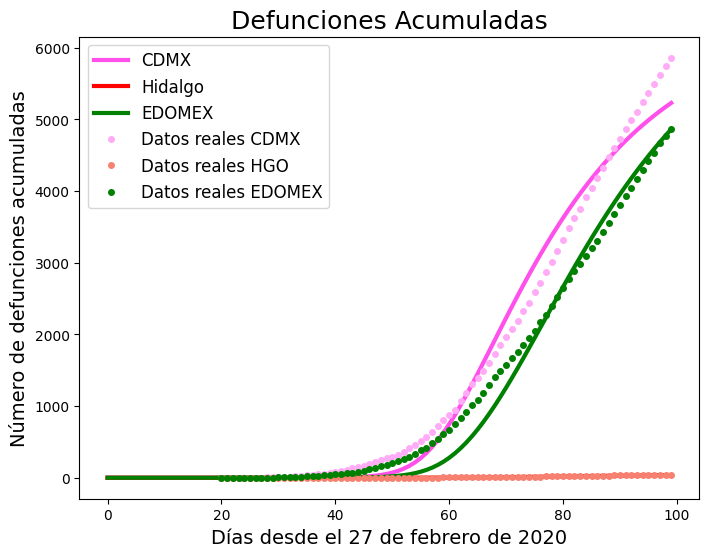

In [27]:
fig, ax = plt.subplots()

# curvas del modelo
ax.plot(Dcdmx, label = 'CDMX', color = '#FF50EC', linewidth = 3)
ax.plot(Dhgo, label = 'Hidalgo', color = 'r', linewidth = 3)
ax.plot(Dedomex, label = 'EDOMEX', color = 'g', linewidth = 3)
# datos reales
# hay que recordar que las defunciones se empezaron a contar 20 días sdespuñes
t = np.linspace(20, 99, 80)
ax.plot(t, data[0], linestyle = 'None', marker = 'o', label = 'Datos reales CDMX',
        markersize = 4, color = '#FFABF6')
ax.plot(t, data[1], linestyle = 'None', marker = 'o', label = 'Datos reales HGO',
        markersize = 4, color = '#F78170')
ax.plot(t, data[2], linestyle = 'None', marker = 'o', label = 'Datos reales EDOMEX',
        markersize = 4, color = 'g')
fig.set_size_inches(8, 6)

ax.set_ylabel('Número de defunciones acumuladas', fontsize = 14)
ax.set_xlabel('Días desde el 27 de febrero de 2020', fontsize = 14)
plt.legend(prop = {'size':12})
plt.title('Defunciones Acumuladas', fontsize = 18)
plt.show()

In [28]:
pob = casos['poblacion'].to_numpy()

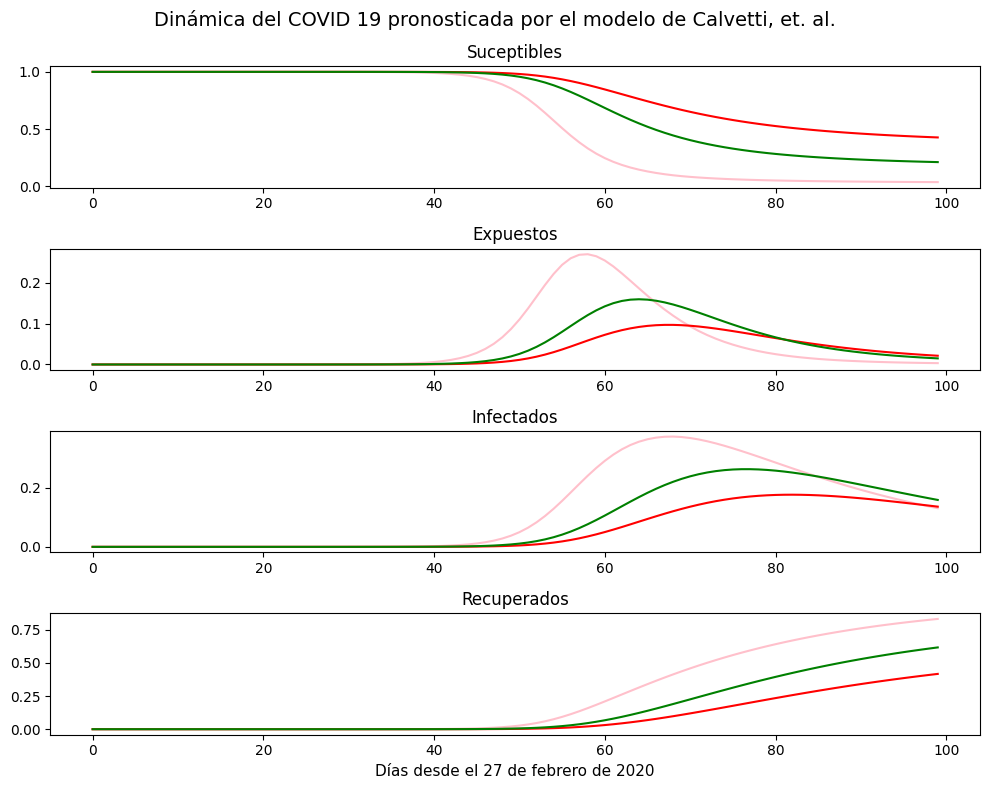

In [29]:
fig, ax = plt.subplots(4)

#  -------------------- suceptibles -------------------------------
Scdmx = sol[0]
Shgo = sol[5]
Sedomex = sol[5*2]

ax[0].plot(Scdmx/pob[0], color = 'pink')
ax[0].plot(Shgo/pob[1], color = 'red')
ax[0].plot(Sedomex/pob[2], color = 'g')
ax[0].set_title('Suceptibles')

# --------------------- expuestos ----------------------------------
Ecdmx = sol[1]
Ehgo = sol[5 + 1]
Eedomex = sol[5*2 + 1]

ax[1].plot(Ecdmx/pob[0], color = 'pink')
ax[1].plot(Ehgo/pob[1], color = 'red')
ax[1].plot(Eedomex/pob[2], color = 'g')
ax[1].set_title('Expuestos')

# ----------------------- infectados ------------------------------
Icdmx = sol[2]
Ihgo = sol[5 + 2]
Iedomex = sol[5*2 + 2]

ax[2].plot(Icdmx/pob[0], color = 'pink')
ax[2].plot(Ihgo/pob[1], color = 'red')
ax[2].plot(Iedomex/pob[2], color = 'g')
ax[2].set_title('Infectados')

# ---------------------- recuperados ------------------------------
Rcdmx = sol[3]
Rhgo = sol[5 + 3]
Redomex = sol[5*2 + 3]

ax[3].plot(Rcdmx/pob[0], color = 'pink')
ax[3].plot(Rhgo/pob[1], color = 'red')
ax[3].plot(Redomex/pob[2], color = 'g')
ax[3].set_title('Recuperados')
ax[3].set_xlabel('Días desde el 27 de febrero de 2020', fontsize = 11)


plt.suptitle("Dinámica del COVID 19 pronosticada por el modelo de Calvetti, et. al.", fontsize = 14)
fig.set_size_inches(10, 8)
fig.tight_layout()
plt.show()